In [1]:
import polars as pl
from kmodes.kmodes import KModes
from polars import DataFrame
from sklearn import preprocessing
import altair as alt
import numpy as np
from sklearn.metrics import confusion_matrix
np.random.seed(42)

## Load the dataset

In [2]:
df = pl.read_csv('Data-Mushroom/mushrooms.csv', skip_rows=2)
df.head()

class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""p""","""x""","""s""","""n""","""t""","""p""","""f""","""c""","""n""","""k""","""e""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""k""","""s""","""u"""
"""e""","""x""","""s""","""y""","""t""","""a""","""f""","""c""","""b""","""k""","""e""","""c""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""n""","""n""","""g"""
"""e""","""b""","""s""","""w""","""t""","""l""","""f""","""c""","""b""","""n""","""e""","""c""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""n""","""n""","""m"""
"""p""","""x""","""y""","""w""","""t""","""p""","""f""","""c""","""n""","""n""","""e""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""k""","""s""","""u"""
"""e""","""x""","""s""","""g""","""f""","""n""","""f""","""w""","""b""","""k""","""t""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""e""","""n""","""a""","""g"""


In [3]:
df.describe()

statistic,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""count""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124""","""8124"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""min""","""e""","""b""","""f""","""b""","""f""","""a""","""a""","""c""","""b""","""b""","""e""","""?""","""f""","""f""","""b""","""b""","""p""","""n""","""n""","""e""","""b""","""a""","""d"""
"""25%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""max""","""p""","""x""","""y""","""y""","""t""","""y""","""f""","""w""","""n""","""y""","""t""","""r""","""y""","""y""","""y""","""y""","""p""","""y""","""t""","""p""","""y""","""y""","""w"""


In [4]:
y = df.select('class')
x = df.drop('class')

In [5]:
x.schema

Schema([('cap-shape', String),
        ('cap-surface', String),
        ('cap-color', String),
        ('bruises', String),
        ('odor', String),
        ('gill-attachment', String),
        ('gill-spacing', String),
        ('gill-size', String),
        ('gill-color', String),
        ('stalk-shape', String),
        ('stalk-root', String),
        ('stalk-surface-above-ring', String),
        ('stalk-surface-below-ring', String),
        ('stalk-color-above-ring', String),
        ('stalk-color-below-ring', String),
        ('veil-type', String),
        ('veil-color', String),
        ('ring-number', String),
        ('ring-type', String),
        ('spore-print-color', String),
        ('population', String),
        ('habitat', String)])

In [6]:
df.null_count()

class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preprocessing data


In [7]:
encoder = preprocessing.LabelEncoder()
x = x.select(
    [
        pl.all().map_batches(encoder.fit_transform)
    ]
)

In [8]:
x.head()

cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,3,5
5,2,9,1,0,1,0,0,4,0,2,2,2,7,7,0,2,1,4,3,2,1
0,2,8,1,3,1,0,0,5,0,2,2,2,7,7,0,2,1,4,3,2,3
5,3,8,1,6,1,0,1,5,0,3,2,2,7,7,0,2,1,4,2,3,5
5,2,3,0,5,1,1,0,4,1,3,2,2,7,7,0,2,1,0,3,0,1


In [9]:
unique_counts = x.select(pl.all().n_unique())
single_unique_cols = [unique_counts.columns[i]
                      for i, val in enumerate(unique_counts.row(0))
                      if val == 1]
x = x.drop(single_unique_cols)

## Clustering using K-Modes


In [10]:
km = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)  # Huang, Cao, random

In [11]:
clusters = km.fit_predict(x)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 780, cost: 62474.0
Run 1, iteration: 2/100, moves: 0, cost: 62474.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 733, cost: 63972.0
Run 2, iteration: 2/100, moves: 0, cost: 63972.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 582, cost: 65013.0
Run 3, iteration: 2/100, moves: 224, cost: 64970.0
Run 3, iteration: 3/100, moves: 17, cost: 64970.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 595, cost: 63851.0
Run 4, iteration: 2/100, moves: 148, cost: 63851.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2712, cost: 64120.0
Run 5, iteration: 2/100, moves: 340, cost: 64120.0
Best run was number 1


In [12]:
yp = DataFrame({
    'predicted-label': clusters
})
yp.head()

predicted-label
u16
0
0
0
0
0


In [13]:
counting = yp.select(pl.col('predicted-label').value_counts()).unnest('predicted-label')

pie = (alt.Chart(counting).mark_arc()
.encode(
    theta=alt.Theta('count', stack='normalize', type='quantitative'),
    color=alt.Color('predicted-label', type='nominal'),
    tooltip=['predicted-label', 'count:N'],
))

pie

alt.Chart(...)

In [14]:
encoded_y = y.select(pl.all().map_batches(encoder.fit_transform))

In [15]:
encoded_y.head()

class
i64
1
0
0
1
0


In [16]:
print(f'in this encoding, {encoded_y.row(0)} represents {y.row(0)}')

in this encoding, (1,) represents ('p',)


## Evaluation

In [17]:
labels = DataFrame({
    'y': encoded_y,
    'yp': clusters
})
labels.head()

y,yp
i64,u16
1,0
0,0
0,0
1,0
0,0


In [18]:
values_count = labels.group_by(['y', 'yp']).len()
values_count

y,yp,len
i64,u16,u32
1,1,3088
1,0,828
0,1,28
0,0,4180


In [19]:
cf_matrix = confusion_matrix(encoded_y, clusters)
cf_df = DataFrame({
    'True Label': np.repeat(np.arange(cf_matrix.shape[0]), cf_matrix.shape[1]),
    'Predicted Label': np.tile(np.arange(cf_matrix.shape[1]), cf_matrix.shape[0]),
    'Count': cf_matrix.flatten()
})

heatmap = alt.Chart(cf_df).mark_rect().encode(
    x='Predicted Label:O',
    y='True Label:O',
    color='Count:Q',
    tooltip=['True Label', 'Predicted Label', 'Count']
).properties(
    width=300,
    height=300
)

heatmap

alt.Chart(...)

[[0.51452486 0.00344658]
 [0.10192024 0.38010832]]


Text(0.5, 23.52222222222222, 'Predicted Labels')

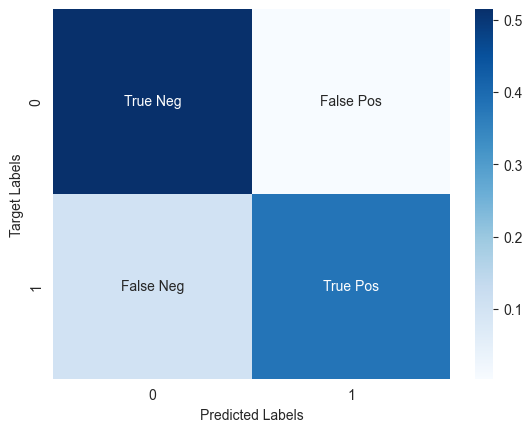

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

cf_matrix = confusion_matrix(encoded_y, clusters)
print(cf_matrix/np.sum(cf_matrix))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(1, 1)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt='', cmap='Blues')
ax.set_ylabel('Target Labels')
ax.set_xlabel('Predicted Labels')

In [21]:
labels = DataFrame({
    'y': encoded_y,
    'yp': clusters
})

In [22]:
from sklearn.metrics import rand_score, adjusted_rand_score

ri = rand_score(labels.select('y').to_numpy().flatten(), labels.select('yp').to_numpy().flatten())
ari = adjusted_rand_score(y.to_numpy().flatten(), clusters)

print(f'Rand Index: {ri}')
print(f'Adjusted Rand Index: {ari}')

Rand Index: 0.8114474930707483
Adjusted Rand Index: 0.6228711271435307


In [23]:
True_neg = cf_matrix[0,0]
False_pos = cf_matrix[0,1]
True_pos = cf_matrix[1,1]
False_neg = cf_matrix[1,0]

accuracy = (True_neg + True_pos)/(True_neg + False_neg + True_pos + False_pos)
recall = (True_pos)/(False_neg+True_pos)
precision = (True_pos)/(False_pos + True_pos)
F1_score = 2 * ((precision*recall)/(precision+recall))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1_score: {F1_score}')

Accuracy: 0.8946331856228459
Recall: 0.7885597548518897
Precision: 0.9910141206675225
F1_score: 0.8782707622298066
